# Amazon Deforestation Activity Forecasting Using AI/ML and IoT Data


## Part III: LSTM Model Training and Evaluation for Deforestation Activity
## AAI-530 Team 8 Final Project

Team 8:  Tyler Foreman

University of San Diego, Applied Artificial Intelligence

Date:  Feburary 26, 2023

GitHub Repository: https://github.com/t4ai/amazon-deforestation-forecasting

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [64]:
import keras
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Input, Embedding, Concatenate
from keras.layers  import Activation
from keras.utils import pad_sequences
from keras import activations
import random
import tensorflow as tf
from matplotlib.lines import Line2D
from sklearn.preprocessing import MinMaxScaler

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load geo data layers from our data dir
root_dir = '/content/drive/MyDrive/USD/datasets/amazon_deforestation'

## Load the Prepared Dataset

Read in the dataset prepared in Stage I and II.  Load into DataFrame.

In [36]:
# Save to file for use in visualizations
new_prediction_data_cluster = pd.read_csv('/content/drive/MyDrive/USD/datasets/amazon_deforestation/deforestation_cluster_prepared.csv')

In [37]:
new_prediction_data_cluster.head(25)

,Unnamed: 0.1,Unnamed: 0,cluster,year,deforest_area_km,activity_count,state,state_area,state_hydro_area,state_no_forest_area,cluster_area,cluster_no_forest_area,cluster_hydro_area,years_from_start,cluster_name
0,0,0,0,2000,32.123764,334,AC,1.707994e+08,113.339475,70.051073,2.220243e+07,911.288216,3986.697243,0,cl_0
1,1,0,0,2001,32.123764,334,AC,1.707994e+08,113.339475,70.051073,2.220243e+07,911.288216,3986.697243,1,cl_0
2,2,0,0,2002,32.123764,334,AC,1.707994e+08,113.339475,70.051073,2.220243e+07,911.288216,3986.697243,2,cl_0
3,3,0,0,2003,32.123764,334,AC,1.707994e+08,113.339475,70.051073,2.220243e+07,911.288216,3986.697243,3,cl_0
4,4,0,0,2004,32.123764,334,AC,1.707994e+08,113.339475,70.051073,2.220243e+07,911.288216,3986.697243,4,cl_0
5,5,0,0,2005,32.123764,334,AC,1.707994e+08,113.339475,70.051073,2.220243e+07,911.288216,3986.697243,5,cl_0
6,6,0,0,2006,32.123764,334,AC,1.707994e+08,113.339475,70.051073,2.220243e+07,911.288216,3986.697243,6,cl_0
7,7,0,0,2007,32.123764,334,AC,1.707994e+08,113.339475,70.051073,2.220243e+07,911.288216,3986.697243,7,cl_0
8,8,15,0,2008,32.123764,334,AC,1.707994e+08,113.339475,70.051073,2.220243e+07,911.288216,3986.697243,8,cl_0
9,9,16,0,2009,14.786516,184,AC,1.707994e+08,113.339475,70.051073,2.220243e+07,911.288216,3986.697243,9,cl_0


### Do a little clean up to filter out static years
For the Darts TFT model, we needed at least 19 years for the model to work.  So a BFILL was performed to populate back history.  We will not need that for this model.

In [38]:
# filter out synthetic entries
new_prediction_data_cluster = new_prediction_data_cluster[new_prediction_data_cluster['year']>2007]

In [23]:
# order by year
#new_prediction_data_cluster = new_prediction_data_cluster.sort_values(by=['year'])

In [39]:
# inspect
new_prediction_data_cluster.head(25)

,Unnamed: 0.1,Unnamed: 0,cluster,year,deforest_area_km,activity_count,state,state_area,state_hydro_area,state_no_forest_area,cluster_area,cluster_no_forest_area,cluster_hydro_area,years_from_start,cluster_name
8,8,15,0,2008,32.123764,334,AC,1.707994e+08,113.339475,70.051073,2.220243e+07,911.288216,3986.697243,8,cl_0
9,9,16,0,2009,14.786516,184,AC,1.707994e+08,113.339475,70.051073,2.220243e+07,911.288216,3986.697243,9,cl_0
10,10,17,0,2010,26.154619,300,AC,1.707994e+08,113.339475,70.051073,2.220243e+07,911.288216,3986.697243,10,cl_0
11,11,18,0,2011,20.546779,230,AC,1.707994e+08,113.339475,70.051073,2.220243e+07,911.288216,3986.697243,11,cl_0
12,12,19,0,2012,34.443481,348,AC,1.707994e+08,113.339475,70.051073,2.220243e+07,911.288216,3986.697243,12,cl_0
13,13,20,0,2013,16.741396,213,AC,1.707994e+08,113.339475,70.051073,2.220243e+07,911.288216,3986.697243,13,cl_0
14,14,21,0,2014,38.795141,419,AC,1.707994e+08,113.339475,70.051073,2.220243e+07,911.288216,3986.697243,14,cl_0
15,15,22,0,2015,5.143917,55,AC,1.707994e+08,113.339475,70.051073,2.220243e+07,911.288216,3986.697243,15,cl_0
16,16,23,0,2016,16.078545,199,AC,1.707994e+08,113.339475,70.051073,2.220243e+07,911.288216,3986.697243,16,cl_0
17,17,24,0,2017,15.751918,170,AC,1.707994e+08,113.339475,70.051073,2.220243e+07,911.288216,3986.697243,17,cl_0


### Create Train and Validation Datasets
Load dataframe into TimeSeriesDataSet and split at prediction horizon (5 years) for train/test

In [40]:
# don't use any future looking dates for training
train_val_df = new_prediction_data_cluster[new_prediction_data_cluster['year']<2023]

In [42]:
max_cluster_id = train_val_df['cluster'].max()

In [47]:
# split dataset at 3 year time horizon
train_df = train_val_df[train_val_df['cluster']<int(max_cluster_id * .8)]
val_df = train_val_df[train_val_df['cluster']>=int(max_cluster_id * .8)]

In [48]:
print("Training samples:", len(train_df))
print("Test samples:", len(val_df))

Training samples: 26655
Test samples: 6690


## Model 2: Build and Train LSTM Model to predict new deforestation activity by year for each cluster

Build and optimize an LSTM to make activity predictions



### Helper Functions

In [100]:
# build input and label sequences for LSTM training or validation
def build_lstm_sequences(df, seq_length, ph, feat_cols, target_col):
    seq_arrays = []
    seq_labs = []

    #create list of sequence length GAP readings
    num_rows = len(df)

    #create list of sequence length feature lists and labels
    for start in range(0,num_rows-seq_length-ph):
        seq_arrays.append(df[feat_cols].iloc[start:start+seq_length].to_numpy())
        seq_labs.append(df[target_col].iloc[start+seq_length:start+seq_length+ph].to_numpy()[-1])

    #convert to numpy arrays and floats to appease keras/tensorflow
    seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
    seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)
    print(seq_labs.shape)
    assert(seq_arrays.shape == (len(df)-seq_length-ph,seq_length, len(feat_cols)))
    assert(seq_labs.shape == (len(df)-seq_length-ph,))

    return seq_arrays, seq_labs

def build_lstm_embedding_sequences(df, seq_length, ph, feat_cols, cluster_col, target_col):
    seq_arrays_1 = []
    seq_arrays_2 = []
    seq_labs = []

    #create list of sequence length GAP readings
    num_rows = len(df)

    #create list of sequence length feature lists and labels
    for start in range(0,num_rows-seq_length-ph):
        seq_arrays_1.append(df[feat_cols].iloc[start:start+seq_length].to_numpy())
        seq_arrays_2.append(df[cluster_col].iloc[start:start+seq_length].to_numpy())
        seq_labs.append(df[target_col].iloc[start+seq_length:start+seq_length+ph].to_numpy()[-1])

    #convert to numpy arrays and floats to appease keras/tensorflow
    seq_arrays_1 = np.array(seq_arrays_1, dtype = object).astype(np.float32)
    seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

    assert(seq_arrays_1.shape == (len(df)-seq_length-ph,seq_length, len(feat_cols)))
    assert(seq_labs.shape == (len(df)-seq_length-ph,))

    return seq_arrays_1, seq_arrays_2, seq_labs

def build_lstm_val_sequences(df, seq_length, ph, feat_cols, target_col):
    val_arrays = []
    val_labs = []

    num_rows = len(df)
    curr_readings = 2

    for start in range(0,num_rows-seq_length-ph):
        if(curr_readings < seq_length):
            x_array = df[feat_cols].iloc[start:start+curr_readings].to_numpy()
            y_array = df[target_col].iloc[start+curr_readings:start+curr_readings+ph].to_numpy()[-1]
        else:
            x_array = df[feat_cols].iloc[start:start+seq_length].to_numpy()
            y_array = df[target_col].iloc[start+seq_length:start+seq_length+ph].to_numpy()[-1]

        val_arrays.append(x_array)
        val_labs.append(y_array)
        curr_readings = curr_readings + 1

    # use the pad_sequences function on your input sequences
    # remember that we will later want our datatype to be np.float32
    val_arrays = tf.keras.utils.pad_sequences(val_arrays, maxlen=seq_length, padding='pre', dtype=np.float32)

    #convert labels to numpy arrays and floats to appease keras/tensorflow
    val_labs = np.array(val_labs, dtype = object).astype(np.float32)

    assert(val_arrays.shape == (len(df)-seq_length-ph,seq_length, len(feat_cols)))
    assert(val_labs.shape == (len(df)-seq_length-ph,))

    return val_arrays, val_labs

# build a sequence to make a future prediction from
def build_lstm_future_sequences(df, seq_length, ph, feat_cols):
    val_arrays = []
    num_rows = len(df)

    # get sequences to make ph predicitons
    for start in range(num_rows-ph,num_rows):
        x_array = df[feat_cols].iloc[start:start+seq_length].to_numpy()
        val_arrays.append(x_array)

    #x_array = df[feat_cols].iloc[num_rows-seq_length:num_rows].to_numpy()
    #val_arrays.append(x_array)

    # use the pad_sequences function on your input sequences
    # remember that we will later want our datatype to be np.float32
    val_arrays = tf.keras.utils.pad_sequences(val_arrays, maxlen=seq_length, padding='pre', dtype=np.float32)

    return val_arrays

# build LSTM model with specified layers and units
def build_lstm_model(nb_features, nb_out, seq_length, lstm_layer_units=[5, 3]):
    model = Sequential()

    for idx, lstm_layer_unit in enumerate(lstm_layer_units):
        #add LSTM layer
        return_seq = True
        if(idx == len(lstm_layer_units) - 1):
            return_seq = False
        model.add(LSTM(
                input_shape=(seq_length, nb_features),
                units=lstm_layer_unit,
                return_sequences=return_seq))
        #model.add(Dropout(0.2))

    # add dense output layer
    model.add(Dense(units=nb_out))
    model.add(Activation(activations.linear))
    optimizer = keras.optimizers.Adam(learning_rate = 0.01)
    model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
    return model

# build LSTM model with embedding specified layers and units
def build_embedded_lstm_model(nb_features, nb_out, seq_length, cluster_len):

    # define input layers
    input_1 = Sequential()
    input_1.add(Input(shape=(nb_features, )))

    input_2 = Sequential()
    input_2.add(Input(shape=(1,)))

    # mege input layers
    merge_1 = Concatenate([input_1, input_2])

    # define LSTM
    lstm = Sequential()
    lstm.add(LSTM(input_shape=(seq_length, nb_features), units=64, return_sequences=True))
    lstm.add(LSTM(input_shape=(seq_length, nb_features), units=32, return_sequences=True))
    lstm.add(LSTM(input_shape=(seq_length, nb_features), units=16, return_sequences=True))
    lstm.add(LSTM(input_shape=(seq_length, nb_features), units=8, return_sequences=False))
    lstm.add(Dense(units=nb_out))
    lstm.add(Activation(activations.linear))

    # merge inputs with LSTM
    #merge_final = Concatenate([merge_1, lstm])

    model = Sequential()
    model.add(merge_1)
    model.add(lstm)

    # build model
    optimizer = keras.optimizers.Adam(learning_rate = 0.01)
    model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
    model.build(input_shape=(1, 1, ))
    model.summary()
    return model

# fit the lstm model
def train_lstm_model(model, input_seq, label_seq, epochs, batch_size, model_path):
    history = model.fit(input_seq, label_seq, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=epochs, verbose=1, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
    return history, model

# visualize model loss
def visualize_model_loss(history):
    fig_acc = plt.figure(figsize=(10, 10))
    #plt.plot(history.history['loss'])
    plt.plot(history.history['val_mse'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['val'], loc='upper left')
    plt.show()

### Build train sequences and Define LSTM Model

In [112]:
# build our train sequences
feature_cols = ['activity_count']
target_col = 'activity_count'
ph = 3
seq_len = 12
x_train_seq, y_train_seq = build_lstm_sequences(train_df, seq_len, ph, feature_cols, target_col)

(26640,)


In [113]:
# build our model
lstm_model = build_lstm_model(len(feature_cols), y_train_seq.shape[0], seq_len, [32, 16, 8])
print(lstm_model.summary())

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 12, 32)            4352      
                                                                 
 lstm_51 (LSTM)              (None, 12, 16)            3136      
                                                                 
 lstm_52 (LSTM)              (None, 8)                 800       
                                                                 
 dense_16 (Dense)            (None, 26640)             239760    
                                                                 
 activation_12 (Activation)  (None, 26640)             0         
                                                                 
Total params: 248048 (968.94 KB)
Trainable params: 248048 (968.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [114]:
# train our model - use mini-batches of 8 clusters
history, lstm_model = train_lstm_model(lstm_model, x_train_seq, y_train_seq, 100, 96, 'lstm__activity_1.h5')

Epoch 1/100
264/264 - 7s - loss: 101384.3125 - mse: 101384.3125 - val_loss: 102.9010 - val_mse: 102.9010 - 7s/epoch - 25ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


264/264 - 2s - loss: 101068.4141 - mse: 101068.4141 - val_loss: 297.3076 - val_mse: 297.3076 - 2s/epoch - 6ms/step
Epoch 3/100
264/264 - 2s - loss: 100905.5312 - mse: 100905.5312 - val_loss: 7.0163 - val_mse: 7.0163 - 2s/epoch - 6ms/step
Epoch 4/100
264/264 - 2s - loss: 100329.0859 - mse: 100329.0859 - val_loss: 8.4701 - val_mse: 8.4701 - 2s/epoch - 6ms/step
Epoch 5/100
264/264 - 2s - loss: 99838.6875 - mse: 99838.6875 - val_loss: 15.0518 - val_mse: 15.0518 - 2s/epoch - 6ms/step
Epoch 6/100
264/264 - 2s - loss: 99416.5625 - mse: 99416.5625 - val_loss: 25.1364 - val_mse: 25.1364 - 2s/epoch - 6ms/step
Epoch 7/100
264/264 - 2s - loss: 99013.7266 - mse: 99013.7266 - val_loss: 34.8069 - val_mse: 34.8069 - 2s/epoch - 6ms/step
Epoch 8/100
264/264 - 2s - loss: 98640.5391 - mse: 98640.5391 - val_loss: 46.0121 - val_mse: 46.0121 - 2s/epoch - 6ms/step
Epoch 9/100
264/264 - 2s - loss: 98312.3516 - mse: 98312.3516 - val_loss: 59.4074 - val_mse: 59.4074 - 2s/epoch - 6ms/step
Epoch 10/100
264/264 - 2

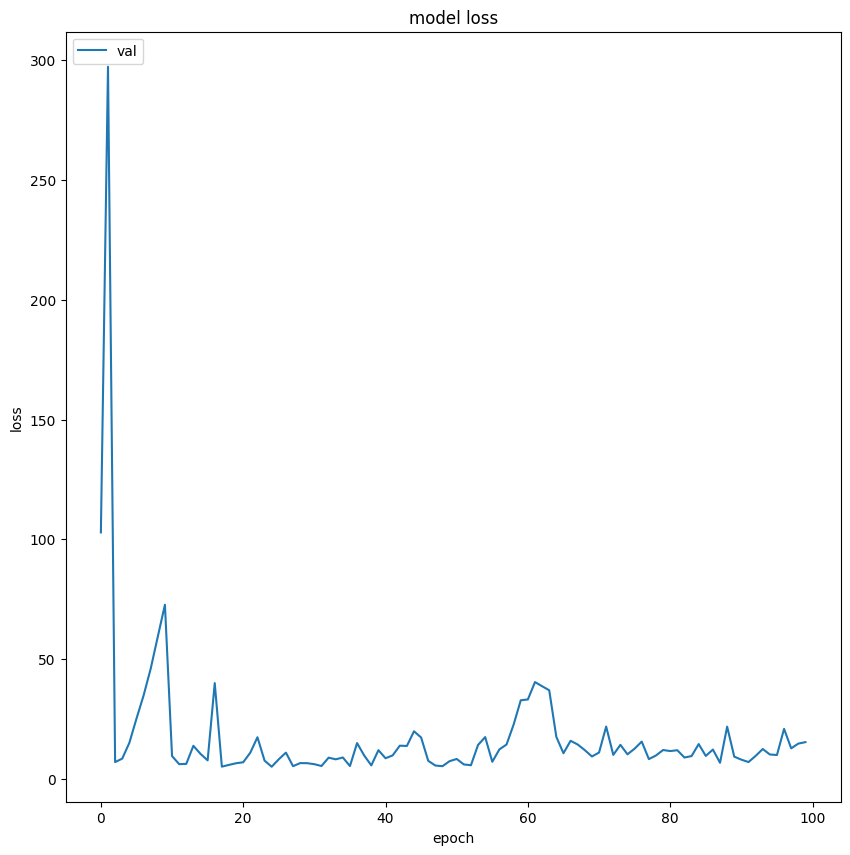

In [115]:
# visualize our training run (loss)
visualize_model_loss(history)

## Evaluate Model Performance

Run some predicitons using the test dataset and visualize the model output vs. ground truth data.

In [185]:
best_lstm_model = tf.keras.models.load_model('/content/drive/MyDrive/USD/datasets/amazon_deforestation/models/lstm/lstm__activity_1.h5')

In [116]:
x_val_seq, y_val_seq = build_lstm_val_sequences(val_df, seq_len, ph, feature_cols, target_col)

In [186]:
scores_test = best_lstm_model.evaluate(x_val_seq, y_val_seq, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = best_lstm_model.predict(x_val_seq)
y_true_test = y_val_seq

test_set = pd.DataFrame(y_pred_test)

209/209 - 2s - loss: 14.0520 - mse: 14.0520 - 2s/epoch - 7ms/step

MSE: 14.052042007446289
209/209 [==============================] - 1s 3ms/step


In [187]:
y_pred_test = best_lstm_model.predict(x_val_seq)
y_true_test = y_val_seq

209/209 [==============================] - 1s 3ms/step


In [189]:
# flatten predictions
y_pred_test_flattened = []
for i in range(len(y_pred_test)):
    y_pred_test_flattened.append(np.max(y_pred_test[i]))

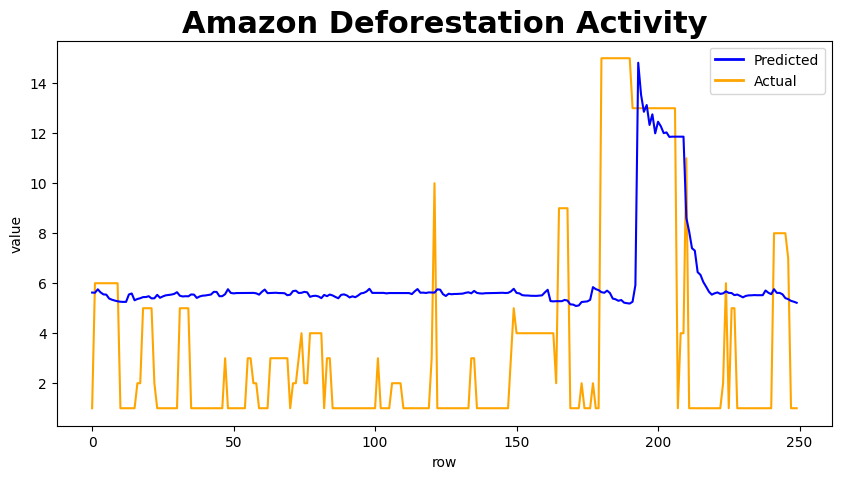

In [162]:
# Plot the predicted data vs. the actual data
# we will limit our plot to 250 predictions for better visualization


custom_lines = [Line2D([0], [0], color='blue', lw=2),
            Line2D([0], [0], color='orange', lw=2)]

fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_true_test[1500:1750], label = 'Actual Value', color='orange')
plt.plot(y_pred_test_flattened[1500:1750], label = 'Predicted Value', color='blue')
plt.title('Amazon Deforestation Activity', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(custom_lines, ['Predicted', 'Actual'])
plt.show()


## Make 5 year predictions by cluster

In [163]:
new_prediction_data_cluster[new_prediction_data_cluster['cluster_name'] == 'cl_4']

,Unnamed: 0.1,Unnamed: 0,cluster,year,deforest_area_km,activity_count,state,state_area,state_hydro_area,state_no_forest_area,cluster_area,cluster_no_forest_area,cluster_hydro_area,years_from_start,cluster_name
100,100,75,4,2008,2295.812858,12154,PA,1.238830e+09,44115.717775,66845.30003,1.019245e+08,976770.773925,3.775357e+06,8,cl_4
101,101,76,4,2009,1101.249905,7622,PA,1.238830e+09,44115.717775,66845.30003,1.019245e+08,976770.773925,3.775357e+06,9,cl_4
102,102,77,4,2010,1496.964962,10422,PA,1.238830e+09,44115.717775,66845.30003,1.019245e+08,976770.773925,3.775357e+06,10,cl_4
103,103,78,4,2011,1246.554038,8979,PA,1.238830e+09,44115.717775,66845.30003,1.019245e+08,976770.773925,3.775357e+06,11,cl_4
104,104,79,4,2012,496.297511,4067,PA,1.238830e+09,44115.717775,66845.30003,1.019245e+08,976770.773925,3.775357e+06,12,cl_4
105,105,80,4,2013,691.862550,5734,PA,1.238830e+09,44115.717775,66845.30003,1.019245e+08,976770.773925,3.775357e+06,13,cl_4
106,106,81,4,2014,556.057112,4680,PA,1.238830e+09,44115.717775,66845.30003,1.019245e+08,976770.773925,3.775357e+06,14,cl_4
107,107,82,4,2015,872.025019,19850,PA,1.238830e+09,44115.717775,66845.30003,1.019245e+08,976770.773925,3.775357e+06,15,cl_4
108,108,83,4,2016,1146.832526,13811,PA,1.238830e+09,44115.717775,66845.30003,1.019245e+08,976770.773925,3.775357e+06,16,cl_4
109,109,84,4,2017,1053.736760,9718,PA,1.238830e+09,44115.717775,66845.30003,1.019245e+08,976770.773925,3.775357e+06,17,cl_4


In [179]:
# build sequences for each cluster
cluster_df = new_prediction_data_cluster[new_prediction_data_cluster['cluster_name'] == 'cl_4']
cluster_df = cluster_df[cluster_df['year'] < 2023]

cluster_seq = build_lstm_future_sequences(cluster_df, 11, 3, feature_cols)

In [180]:
# make prediction for cluster
y_pred_cluster = lstm_model.predict(cluster_seq)

# flatten predictions
y_pred_cluster_flattened = []
for i in range(len(y_pred_cluster)):
    y_pred_cluster_flattened.append(np.max(y_pred_cluster[i]))

1/1 [==============================] - 0s 21ms/step
